In [1]:
from MDP import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

In [2]:
from math import floor

### Define the GridWorld

(Creating Willemsen Gridworld)


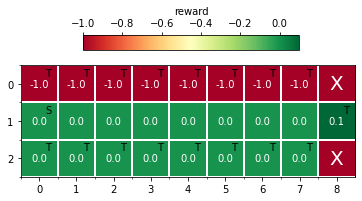

In [18]:
# Create the gridworld, and set cell values to equal rewards
print('(Creating Willemsen Gridworld)')
grid = np.ones((3, 9)) * -1
grid[1,:8] = 0
grid[1, 8] = 0.1
grid[2, :8] = 0
terminal_state = []
for i in [0,2]:
    for j in range(8):
        terminal_state.append([i,j])
terminal_state.append([1,8])
terminal_state = np.array(terminal_state)
initial_state = np.array([1, 0])
blacked_state = np.array([[0, 8],[2, 8]])

fig, ax, im, cb = plot_gridworld(grid, terminal_state, initial_state, blacked_state, fig=None, ax=None, show=True)

n_episodes = 1
max_steps = 40
gamma = 0.8
alpha = 0.1
epsilon = 0.05

Learn = True
batch_size = 1

env = gridworld(grid, terminal_state, initial_state, blacked_state, max_steps)

### Initialize Parameters

In [19]:
E = [Estimator(approximator=bellman_N_table(alpha=0.1, gamma=0.8), mask=identity()),
    Estimator(approximator=bellman_Q_table(alpha=0.1, gamma=0.8), mask=identity()),
    Estimator(approximator=table(), mask=arrival_state())]
B = ReplayMemory(max_size=10000)
T = [Target()]

### Generate Trajectories

In [20]:
agent = Agent(buffer=B, targets=T, estimators=E)

epsilons = np.flip(np.linspace(0.05, 1, n_episodes))
trajectories = []

for i in tqdm(range(n_episodes)):
    trajectory = run_trajectory(env, agent, epsilons[i], abstract=False)
    
    trajectories.append(trajectory)

  0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
trajectory[0].action

'down'

In [21]:
q_table = agent.estimators[1].approximator.table
visits = agent.estimators[2].approximator.table
n_table = agent.estimators[0].approximator.table
n_visits = agent.estimators[0].visits

In [28]:
n_table

{}

In [22]:
{str(key.array): v for key,v in visits.items()} 

{}

In [23]:
{str(key.array): v for key,v in n_visits.items()} 

{}

### Process Trajectories

In [26]:
returns_table = cumulative_table(trajectories, gamma, Qpi_sa, q_table)
rho = state_dist(visits)
abs_action = action_abstraction(returns_table, rho)
sa_values, a_values, bias_squared = action_abstraction_bias(returns_table, abs_action)
heatmap = generate_heatmap(grid, rho)
heatmapQ = generate_heatmap(grid, q_table, aggf=lambda x: max(v for v in x.values()))
n_maps = {}
for a in agent.actions:
    n_maps[a] = generate_heatmap(grid, n_table, aggf=lambda x: x[a])
    
nt_maps = {}
for a in agent.actions:
    hm = np.copy(grid)*0
    for state, actions in n_visits.items():
        if a in list(actions.keys()):
            hm[int(state[1]), int(state[3])] = actions[a]
    nt_maps[a] = hm

{}


KeyError: <MDP.environments.State object at 0x0000020D938CAA30>

### Plot Results

In [ ]:
# First plot
%matplotlib notebook
print('(Plotting 1 of 1)')
fig, ax = plt.subplots(ncols=2, nrows=6, figsize=(8, 12))

ax[0, 0].scatter(sa_values, a_values)
ax[0, 0].set_title('Bias plot')
ax[0, 0].set_xlabel('state action pair value')
ax[0, 0].set_ylabel('action abstraction value')
#ax[0, 0].set_ylim((0, 40))

ax[0, 1].hist(bias_squared, cumulative=True, bins=25)
ax[0, 1].set_title('Bias squared plot')
ax[0, 1].set_xlabel(r'$(v_{sa} - v_{a})^2$')
ax[0, 1].set_ylabel('freq')
# plt.ylim((0, 40))

ax[1, 0].imshow(heatmap, cmap='binary')
ax[1, 0].set_title('gridworld visits heatmap')

ax[1, 1].imshow(heatmapQ, cmap='binary')
ax[1, 1].set_title('gridworld qvalues')

ind = 4
for action, n_map in n_maps.items():
    x,y = (floor(ind/2), ind%2)
    ax[x,y].imshow(n_maps[action], cmap='binary')
    ax[x,y].set_title('n_values for action: %s' % action)
    ind += 1

for action, n_map in n_maps.items():
    x,y = (floor(ind/2), ind%2)
    ax[x,y].imshow(nt_maps[action], cmap='binary')
    ax[x,y].set_title('n_visits for action: %s' % action)
    ind += 1

plt.tight_layout()
plt.show()